# Can fingerprint distances discriminate DFG conformations?

The `kissim` fingerprint encodes the pocket residues' spatial distance to four centers&mdash;the pocket centroid, hinge region, DFG region and front pocket&mdash;and should therefore discriminate between two structures in different conformations; when we compare two structures in *different* conformations the fingerprint distance should be higher than for two structures in *similar* conformations.

Let's check if this is true using DFG conformations from KLIFS. Plot distribution of fingerprint distances grouped by in/in, out/out, and in/out pairs.

- Use fingerprint distances for structure pairs between all kinases
- Use fingerprint distances for structure pairs between the same kinase

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from opencadd.databases.klifs import setup_remote
from kissim.comparison import FingerprintDistanceGenerator

from src.definitions import COVERAGE_CUTOFF

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../results/all"

In [4]:
plt.style.use("seaborn")

## Load fingerprint distances with sufficient coverage

Choose fingerprint distances that are based on spatial distances only (**weighting scheme: 010**) and that are based on a sufficient pairwise fingerprint bit coverage (default: `COVERAGE_CUTOFF`).

In [5]:
COVERAGE_CUTOFF

0.8

In [6]:
# Set path
fingerprint_distance_file = DATA / "fingerprint_distances_010.csv"
# Load data
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")
structure_distances = fingerprint_distance_generator.data
print(f"Number of structure pairs: {structure_distances.shape[0]}")
structure_distances = structure_distances[
    structure_distances["bit_coverage"] >= COVERAGE_CUTOFF
].reset_index(drop=True)
print(f"Number of structure pairs: {structure_distances.shape[0]}")
structure_distances.head()

Number of kinases: 279
Number of structures: 4623
Number of structure pairs: 10683753
Number of structure pairs: 10531755


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,1,2,EphA7,EphA7,0.005340,0.96
1,1,7,EphA7,ITK,0.010538,0.96
2,1,8,EphA7,ITK,0.011114,0.94
3,1,9,EphA7,ITK,0.020569,0.96
4,1,11,EphA7,ITK,0.012521,0.96


## Add DFG conformation

Add DFG conformation from KLIFS to each structure pair.

In [7]:
%%time
klifs_session = setup_remote()
structures = klifs_session.structures.all_structures()
dfg = structures.set_index("structure.klifs_id")["structure.dfg"]
structure_distances["dfg.1"] = structure_distances["structure.1"].apply(lambda x: dfg[x])
structure_distances["dfg.2"] = structure_distances["structure.2"].apply(lambda x: dfg[x])
structure_distances.head()

CPU times: user 1min 3s, sys: 468 ms, total: 1min 3s
Wall time: 1min 5s


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,dfg.1,dfg.2
0,1,2,EphA7,EphA7,0.005340,0.96,out,in
1,1,7,EphA7,ITK,0.010538,0.96,out,in
2,1,8,EphA7,ITK,0.011114,0.94,out,in
3,1,9,EphA7,ITK,0.020569,0.96,out,in
4,1,11,EphA7,ITK,0.012521,0.96,out,in


## Plot DFG conformation pairs

Group the structure pairs by DFG conformation pairs&mdash;in/in, out/out, in/out&mdash;and plot their fingerprint distance distributions.

In [8]:
def structure_distances_by_dfg_conformation_pairs(structure_distances):
    """Distances for all, in/in, out/out, and in/out structure pairs."""

    dfg_in_in = structure_distances[
        (structure_distances["dfg.1"] == "in") & (structure_distances["dfg.2"] == "in")
    ]["distance"]
    dfg_out_out = structure_distances[
        (structure_distances["dfg.1"] == "out") & (structure_distances["dfg.2"] == "out")
    ]["distance"]
    dfg_in_out = structure_distances[
        ((structure_distances["dfg.1"] == "in") & (structure_distances["dfg.2"] == "out"))
        | ((structure_distances["dfg.1"] == "out") & (structure_distances["dfg.2"] == "in"))
    ]["distance"]

    structure_distances_dfg = pd.DataFrame(
        {"in/in": dfg_in_in, "out/out": dfg_out_out, "in/out": dfg_in_out}
    )
    structure_distances_dfg = pd.DataFrame(structure_distances_dfg)

    return structure_distances_dfg

In [9]:
def plot_structure_distances_by_dfg_conformation_pairs(structure_distances, kinase):
    """Plot distribution of structure distances per DFG conformation pair."""

    # Data
    structure_distances_dfg = structure_distances_by_dfg_conformation_pairs(structure_distances)
    print("Number of structure pairs per conformation pair:")
    print(structure_distances_dfg.notna().sum())

    # Boxplot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    structure_distances_dfg.plot(kind="box", ax=ax)
    ax.set_xlabel("Type of conformation pairs")
    ax.set_ylabel("Structure pair distances")
    if kinase is None:
        fig.savefig(
            HERE / "../../notebooks/figures/kissim_discriminates_dfg.png",
            dpi=300,
            bbox_inches="tight",
        )
    else:
        fig.savefig(
            HERE / f"../../notebooks/figures/kissim_discriminates_dfg_{kinase}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()

    # Stats
    display(structure_distances_dfg.describe())

### All structures

Use fingerprint distances for structure pairs between all kinases.

Number of structure pairs per conformation pair:
in/in      8062120
out/out      75078
in/out     1558208
dtype: int64


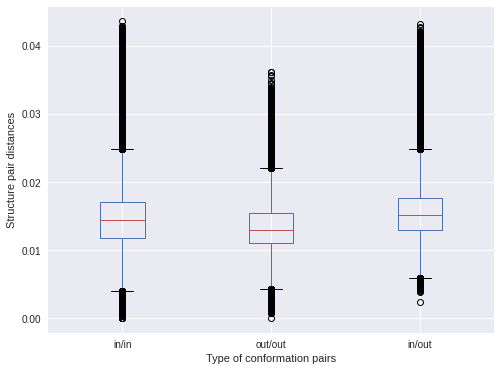

,in/in,out/out,in/out
count,8.062120e+06,75078.000000,1.558208e+06
mean,1.498341e-02,0.013541,1.583247e-02
std,4.988160e-03,0.004448,4.240247e-03
min,0.000000e+00,0.000000,2.376672e-03
25%,1.182187e-02,0.010972,1.299185e-02
50%,1.436762e-02,0.012953,1.513038e-02
75%,1.703727e-02,0.015426,1.770698e-02
max,4.359570e-02,0.036208,4.317481e-02


In [10]:
plot_structure_distances_by_dfg_conformation_pairs(structure_distances, kinase=None)

<div class="alert alert-block alert-info">

When including all kinases at the same time, the distribution of fingerprint distances is similar for structure pairs with the same DFG conformations (in/in and out/out) and different DFG conformations (in/out). 
    
The fingerprint seems not to discriminate DFG-conformations on a kinome-wide level, maybe because the encoded spatial information is not restricted to only DFG conformation features. We may see a disciminative effect when comparing structures for a single kinase.

</div>

### Structures for one kinase

Use fingerprint distances for structure pairs between the same kinase; use only kinases that have a sufficient number of structures in DFG-in and DFG-out conformations (default: 10). 

In [11]:
def kinases_with_high_dfg_in_out_coverage(structure_distances, dfg_structure_coverage_cutoff=10):
    """Given a dataset, get kinases with a threshold DFG in/out coverage."""

    # Get structure KLIFS IDs in our dataset
    structure_klifs_ids = (
        pd.concat(
            [
                structure_distances["structure.1"].drop_duplicates(),
                structure_distances["structure.2"].drop_duplicates(),
            ]
        )
        .drop_duplicates()
        .to_list()
    )
    print(f"Number of structures: {len(structure_klifs_ids)}")

    # Get structural metadata
    klifs_session = setup_remote()
    structures = klifs_session.structures.all_structures()
    structures = structures[structures["structure.klifs_id"].isin(structure_klifs_ids)]

    # Count number of structures per kinase and conformation
    dfg_by_kinase = structures.groupby("kinase.klifs_name").apply(
        lambda x: x["structure.dfg"].value_counts()
    )
    dfg_by_kinase = dfg_by_kinase.reset_index()
    dfg_by_kinase.columns = ["kinase", "dfg", "n_structures"]

    # Keep only in/out rows
    dfg_by_kinase = dfg_by_kinase[(dfg_by_kinase["dfg"] == "in") | (dfg_by_kinase["dfg"] == "out")]

    # Keep only rows with at least xxx structures
    dfg_by_kinase = dfg_by_kinase[dfg_by_kinase["n_structures"] >= dfg_structure_coverage_cutoff]

    # Keep only kinases with both in/out conformations
    n_conformations_by_kinase = dfg_by_kinase.groupby("kinase").size()
    dfg_by_kinase = dfg_by_kinase[
        dfg_by_kinase["kinase"].isin(
            n_conformations_by_kinase[n_conformations_by_kinase == 2].index
        )
    ]

    return dfg_by_kinase.set_index(["kinase", "dfg"])

In [12]:
dfg_by_kinase = kinases_with_high_dfg_in_out_coverage(
    structure_distances, dfg_structure_coverage_cutoff=10
)
dfg_by_kinase

Number of structures: 4590


n_structures
kinase dfg              
BRAF   in             28
       out            21
CDK8   in             21
       out            10
EphA2  in             37
       out            17
MET    in             53
       out            16
p38a   in            111
       out            57

#### BRAF

Number of DFG-in structures: 28
Number of DFG-out structures: 21
Percentage of DFG-in: 57.14%
Number of structure pairs per conformation pair:
in/in      378
out/out    210
in/out     588
dtype: int64


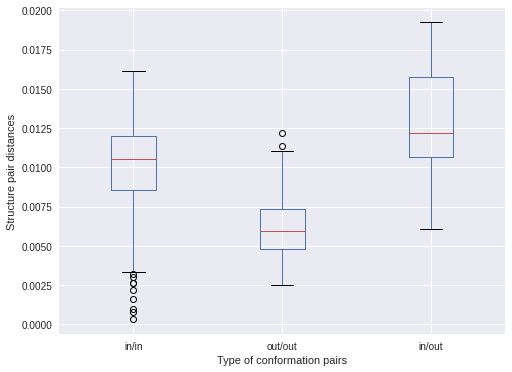

,in/in,out/out,in/out
count,378.000000,210.000000,588.000000
mean,0.010162,0.006233,0.012829
std,0.003254,0.001889,0.003010
min,0.000350,0.002516,0.006065
25%,0.008533,0.004775,0.010640
50%,0.010522,0.005931,0.012167
75%,0.011997,0.007347,0.015752
max,0.016167,0.012214,0.019233


#### CDK8

Number of DFG-in structures: 21
Number of DFG-out structures: 10
Percentage of DFG-in: 67.74%
Number of structure pairs per conformation pair:
in/in      210
out/out     45
in/out     210
dtype: int64


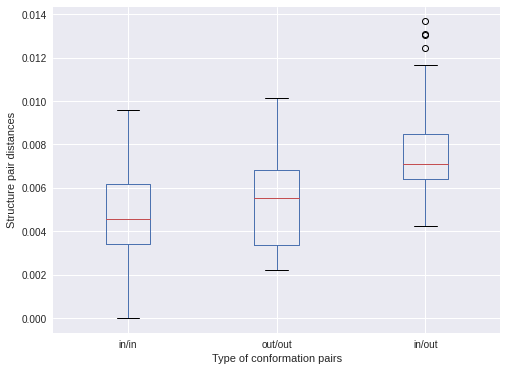

,in/in,out/out,in/out
count,210.000000,45.000000,210.000000
mean,0.004792,0.005586,0.007521
std,0.001733,0.002297,0.001772
min,0.000012,0.002219,0.004262
25%,0.003405,0.003392,0.006392
50%,0.004581,0.005554,0.007103
75%,0.006191,0.006809,0.008492
max,0.009593,0.010141,0.013665


#### EphA2

Number of DFG-in structures: 37
Number of DFG-out structures: 17
Percentage of DFG-in: 68.52%
Number of structure pairs per conformation pair:
in/in      666
out/out    136
in/out     629
dtype: int64


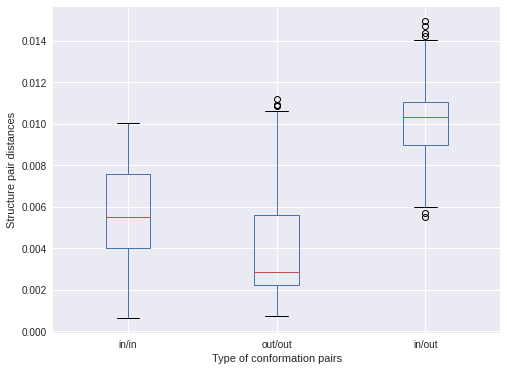

,in/in,out/out,in/out
count,666.000000,136.000000,629.000000
mean,0.005425,0.004503,0.010079
std,0.002358,0.003194,0.001629
min,0.000642,0.000757,0.005527
25%,0.004007,0.002220,0.008995
50%,0.005511,0.002871,0.010340
75%,0.007597,0.005599,0.011051
max,0.010063,0.011205,0.014939


#### MET

Number of DFG-in structures: 53
Number of DFG-out structures: 16
Percentage of DFG-in: 76.81%
Number of structure pairs per conformation pair:
in/in      1378
out/out     120
in/out      848
dtype: int64


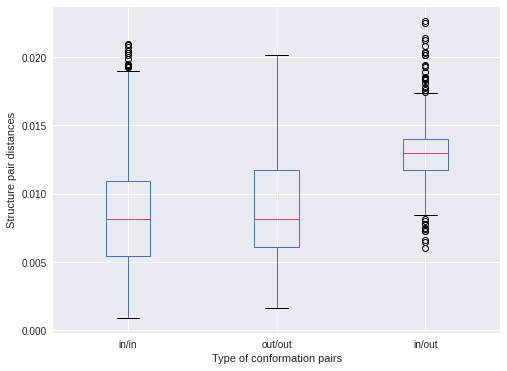

,in/in,out/out,in/out
count,1378.000000,120.000000,848.000000
mean,0.008549,0.009178,0.012970
std,0.004085,0.004515,0.002192
min,0.000898,0.001662,0.005990
25%,0.005462,0.006070,0.011711
50%,0.008132,0.008145,0.012985
75%,0.010944,0.011745,0.013993
max,0.020950,0.020175,0.022619


#### p38a

Number of DFG-in structures: 111
Number of DFG-out structures: 57
Percentage of DFG-in: 66.07%
Number of structure pairs per conformation pair:
in/in      6105
out/out    1596
in/out     6327
dtype: int64


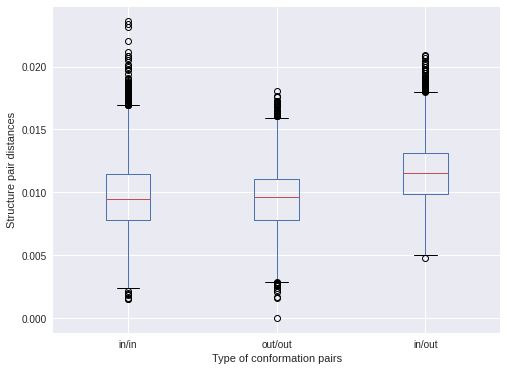

,in/in,out/out,in/out
count,6105.000000,1596.000000,6327.000000
mean,0.009728,0.009453,0.011610
std,0.002929,0.002942,0.002370
min,0.001470,0.000000,0.004794
25%,0.007764,0.007789,0.009891
50%,0.009435,0.009661,0.011546
75%,0.011448,0.011081,0.013126
max,0.023598,0.018030,0.020960


In [13]:
for kinase, dfg in dfg_by_kinase.reset_index().groupby("kinase"):
    display(Markdown(f"#### {kinase}"))
    dfg = dfg.set_index("dfg")
    n_dfg_in = dfg.loc["in", "n_structures"]
    n_dfg_out = dfg.loc["out", "n_structures"]
    print(f"Number of DFG-in structures: {n_dfg_in}")
    print(f"Number of DFG-out structures: {n_dfg_out}")
    dfg_in_percentage = round(n_dfg_in / (n_dfg_in + n_dfg_out) * 100, 2)
    print(f"Percentage of DFG-in: {dfg_in_percentage}%")
    structure_distances_by_kinase = structure_distances[
        (structure_distances["kinase.1"] == kinase) & (structure_distances["kinase.2"] == kinase)
    ].reset_index(drop=True)
    plot_structure_distances_by_dfg_conformation_pairs(structure_distances_by_kinase, kinase)

<div class="alert alert-block alert-info">

We compare here only fingerprint distances for pairs of structures that describe the same kinase. We observe two interesting shifts:
    
1. The distribution for out/out pairs is overall lower than for in/in pairs. Potential explanations: definitions for DFG-out are stricter than for DFG-in; "real" diversity of DFG-out structures could be still unknown due to the lower number of structures for DFG-out than for DFG-in. 
2. The distribution of different DFG conformations (in/out) is overall higher than for equal DFG conformations (in/in and out/out). The fingerprint can discriminate DFG conformations of the same kinase.

</div>